In [1]:
import os
import json
import h5py
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision import models

In [2]:
def loadJson(file_name):
    '''简易加载json'''
    with open(file_name,'r') as f:
        js = json.load(f)
    return js

def saveJson(file, file_name):
    '''简易保存json'''
    with open(file_name,'w') as f:
        json.dump(file,f)

In [3]:
class ToTensor():
    '''
    转为tensor，并且转移到显存中（如果使用显卡）
    20220610 转到显卡中无法使用多进程
    '''
    def __init__(self, device):
        self.device = device
        self.device = 'cpu'
    
    def __call__(self, image:np.ndarray, label:float):
        image = image.transpose(2,0,1)
        image = torch.from_numpy(image).float().to(self.device)
        label = torch.tensor(label).float().to(self.device)
        return image, label

class CropAndResize():
    '''
    中心裁剪+resize
    '''
    def __init__(self, size:int = 96):
        '''
        @param:p:水平翻转和竖直翻转概率
        '''
        self.size = size
    
    def __call__(self, image:torch.tensor, label:torch.tensor):
        '''
        @param:image:图像
        @param:label:标签
        '''
        image = transforms.F.center_crop(image, min(image.shape[-2:]))
        image = transforms.F.resize(image, self.size)
        return image, label

In [4]:
class MyDataset():
    '''
    用于为模型准备数据
    '''
    def __init__(self, anno, phase, keep_ratio, transforms= None):
        '''
        @param:fns:样本名称
        '''
        self.anno  = anno
        self.phase = phase
        self.keep_ratio = keep_ratio
        self.size = len(anno['annotations'])
        np.random.shuffle(self.anno['annotations'])
        self.anno['annotations'] = self.anno['annotations'][:int(keep_ratio*self.size)]
        self.size = len(anno['annotations'])
        self.transforms = transforms
        
    def __call__(self):
        print('使用__getitem__(idx)获取样本号')
    
    def __len__(self):
        '''
        返回样本长度
        '''
        return self.size
    
    
    def __getitem__(self, idx):
        '''
        定义了__getitem__魔法函数，该类就可以下标操作了：[]
        '''
        anno = self.anno['annotations'][idx]
        image_id = anno['image_id']
        c,r,w,h = anno['bbox']
        label = anno['numrical_label']
        image_name = [d['file_name'] for d in self.anno['images'] if d['id'] == image_id][0]
        
        with h5py.File(os.path.join(SAVEROOT, self.phase, image_name),'r') as f:
            image = f['image'][r:r+h,c:c+w,:].astype(np.float32)
            
        if self.transforms:
            for trsf in self.transforms:
                image,label = trsf(image,label)
        return image, label.unsqueeze(0)/100

In [5]:
device = "cuda:0"
path_test = '../data/anno/coco_512/test.json'
anno_test = loadJson(path_test)
SAVEROOT = '../data/anno/coco_512'

In [6]:
test_transforms  = [ToTensor(device), CropAndResize(96)]
test_set  = MyDataset(anno_test , 'test',  1, test_transforms)
test_loader = DataLoader(test_set,
                          batch_size=512,
                          shuffle=False,
                          num_workers=6,
                          pin_memory=True,
                          drop_last=True)

In [34]:
model_path = '../models_reg/models_18_0923/2023092319_Loss_0.003006.pt'
model_reg = models.resnet18(weights=None)
model_reg.conv1 = nn.Conv2d(125, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_reg.fc = nn.Sequential(nn.Linear(512,1),nn.Sigmoid())
model_reg.to(device)
model_reg.load_state_dict(torch.load(model_path))
model_reg.eval()
print('*** model reg 加载完毕 ***')

*** model reg 加载完毕 ***


In [35]:
y = []
y_hat = []
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        print('\r','testing on batch {}'.format(idx), end= '')
        inputs = inputs.to(device)
        labels = labels.to(device) 
        preds = model_reg(inputs)
        y.append(labels)
        y_hat.append(preds)
y = torch.cat(y).cpu().numpy() * 100
y_hat = torch.cat(y_hat).cpu().numpy() * 100

/HOME/scw6493/.conda/envs/cau/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/HOME/scw6493/.conda/envs/cau/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.1

 testing on batch 14

In [11]:
import matplotlib.pyplot as plt

In [36]:
# resnet18
r2 = np.corrcoef(y.ravel(),y_hat.ravel())[0,1]
mean = abs(y - y_hat).mean()
mse = ((y-y_hat)**2).mean()
rmse = mse**0.5
print("resnet18")
print("r2:", r2)
print("mae:", mean)
print("mse:", mse)
print("rmse:",rmse)

resnet18
r2: 0.8954904791144849
mae: 1.9302284
mse: 17.85153
rmse: 4.225107108118473


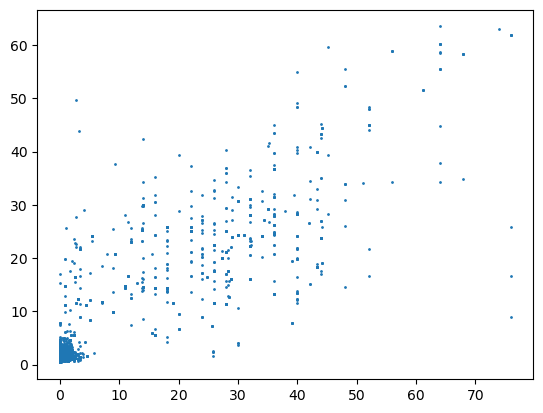

In [33]:
plt.scatter(y, y_hat,s=1)

In [31]:
# resnet34
r2 = np.corrcoef(y.ravel(),y_hat.ravel())[0,1]
mean = abs(y - y_hat).mean()
mse = ((y-y_hat)**2).mean()
rmse = mse**0.5
print("resnet34")
print("r2:", r2)
print("mae:", mean)
print("mse:", mse)
print("rmse:",rmse)

resnet34
r2: 0.846737954770702
mae: 2.6863134
mse: 26.976961
rmse: 5.193935033850949


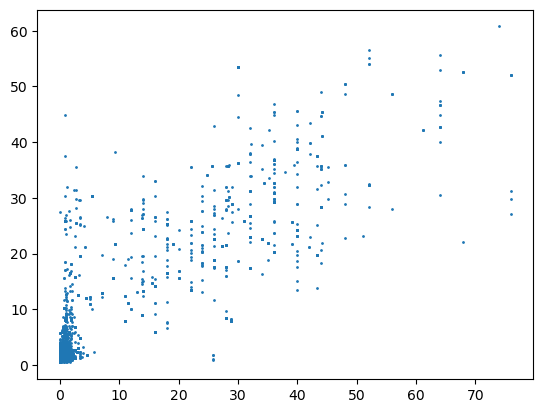

In [40]:
plt.scatter(y, y_hat,s=1)

In [27]:
# resnet50
r2 = np.corrcoef(y.ravel(),y_hat.ravel())[0,1]
mean = abs(y - y_hat).mean()
mse = ((y-y_hat)**2).mean()
rmse = mse**0.5
print("resnet50")
print("r2:", r2)
print("mae:", mean)
print("mse:", mse)
print("rmse:",rmse)

resnet50
r2: 0.8376762973709394
mae: 1.9360768
mse: 26.898342
rmse: 5.186361164879318


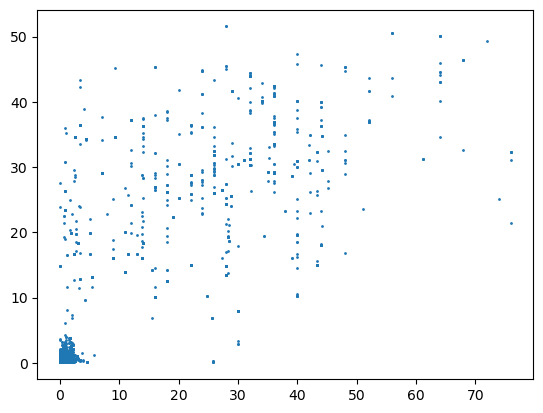

In [12]:
plt.scatter(y, y_hat,s=1)

In [22]:
# resnet101
r2 = np.corrcoef(y.ravel(),y_hat.ravel())[0,1]
mean = abs(y - y_hat).mean()
mse = ((y-y_hat)**2).mean()
rmse = mse**0.5
print("resnet101")
print("r2:", r2)
print("mae:", mean)
print("mse:", mse)
print("rmse:",rmse)

resnet101
r2: 0.8346514400000584
mae: 2.0546982
mse: 28.272205
rmse: 5.317161399918494


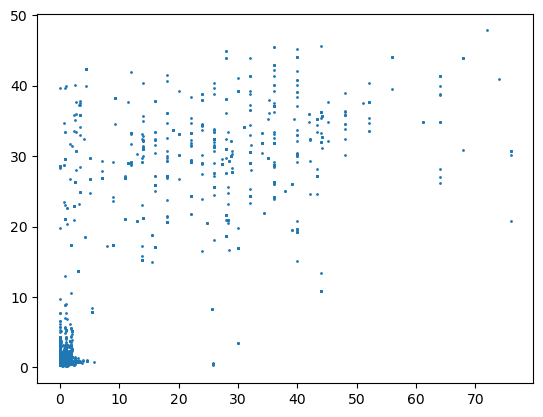

In [16]:
plt.scatter(y, y_hat,s=1)